# Data Exploration

## Import Libraries & Read In Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyreadr
import itertools

In [3]:
data = pyreadr.read_r('../data/IGTdata.rdata')

**Overview of dataset**

In [4]:
print("{:12}| {:57}| {:30}".format('DF NAME','COLUMN NAMES','ROW NAMES'))
print('-'*110)
for key, value in data.items():
    if value.shape[1] > 5:
        column_names = ''.join([', '.join(value.columns[:3]), ',...,', ', '.join(value.columns[-2:])])
    else:
        column_names = ', '.join(value.columns)
    row_names = [str(v) for v in list(value.index.values)]
    row_names = ''.join([', '.join(row_names[:2]), ',...,',', '.join(row_names[-2:])])
    print("{:12}| {:57}| {:30}".format(key,column_names,row_names))

DF NAME     | COLUMN NAMES                                             | ROW NAMES                     
--------------------------------------------------------------------------------------------------------------
choice_95   | Choice_1, Choice_2, Choice_3,...,Choice_94, Choice_95    | Subj_1, Subj_2,...,Subj_14, Subj_15
wi_95       | Wins_1, Wins_2, Wins_3,...,Wins_94, Wins_95              | Subj_1, Subj_2,...,Subj_14, Subj_15
lo_95       | Losses_1, Losses_2, Losses_3,...,Losses_94, Losses_95    | Subj_1, Subj_2,...,Subj_14, Subj_15
index_95    | Subj, Study                                              | 0, 1,...,13, 14               
choice_100  | Choice_1, Choice_2, Choice_3,...,Choice_99, Choice_100   | Subj_1, Subj_2,...,Subj_503, Subj_504
wi_100      | Wins_1, Wins_2, Wins_3,...,Wins_99, Wins_100             | Subj_1, Subj_2,...,Subj_503, Subj_504
lo_100      | Losses_1, Losses_2, Losses_3,...,Losses_99, Losses_100   | Subj_1, Subj_2,...,Subj_503, Subj_504
index_100   | Subj, S

* The studies are grouped by the number of trials (t) completed; 95, 100 or 150. 
* For each group, there are 4 dataframes, where each row correspnds to a subject (s):
  * choice_t : 
    * Entries are either 1, 2, 3 or 4 which correspond to deck A, B, C and D, respectively.
    * Dimensionality is s x t. 
    * The entry of the second row and third column indicates the choice made by the second subject on the third trial.
  * wi_t :
    * Contains the win achieved as a result of each choice.
    * Dimensionality is s x t. 
    * The entry of the second row and third column corresponds to the reward received by the second subject on third trial.
  * lo_t :
    * Contains the loss incurred as a result of each choice.
    * Dimensionality is s x t. 
    * The entry of the second row and third column corresponds to the loss incurred by the second subject on third trial.
  * index_t :
    * Entries are the name of the first author of the study that reports the data name of the first author of the study that reports the data of the corresponding participant.
    * Dimensionality is s x 2. 
    * The entry of the second row indicates which study the second subject participated in.
    

## Data Cleaning & Validation

**Update index_t row names for confirmity.**<br>
All other dataframes have consistent row names of the form Subj_1, Subj_2, Subj_3 etc.

In [5]:
for key, value in data.items():
    if not key[0:5] == 'index':
        continue
    data[key] = value.drop(columns=['Subj'])
    data[key].index = ['Subj_'+str(i) for i in range(1,value.shape[0]+1)]
data['index_150'].head()

,Study
Subj_1,Steingroever2011
Subj_2,Steingroever2011
Subj_3,Steingroever2011
Subj_4,Steingroever2011
Subj_5,Steingroever2011


**Verify table 1 (include link  to it).** <br> {cite:t}`Steingroever_Fridberg_Horstmann_Kjome_Kumari_Lane_Maia_McClelland_Pachur_Premkumar` speculates that the sample size may be less than 617 due to "missing data for one participant in {cite:t}`kjome_lane_schmitz_green_ma_prasla_swann_moeller_2010`, and for two participants in {cite:t}`Wood_Busemeyer_Koling_Cox_Davis_2005`". According to table 1 (link again), there should be 19 participants in {cite:t}`kjome_lane_schmitz_green_ma_prasla_swann_moeller_2010` and 153 in {cite:t}`Wood_Busemeyer_Koling_Cox_Davis_2005`.

In [6]:
print("Total number of subjects:", data['choice_95'].shape[0] + data['choice_100'].shape[0] + data['choice_150'].shape[0])

Total number of subjects: 617


Appears in order, let's take a closer look to be sure.

In [7]:
print("Subjects in Kjome study:", len(data['index_100'][data['index_100']['Study'] == 'Kjome']))
print("Subjects in Wood study:", len(data['index_100'][data['index_100']['Study'] == 'Wood']))

Subjects in Kjome study: 19
Subjects in Wood study: 153


Confirms correct number of subjects reported.

**Check for nulls/ unexpected entries**

Sanity checking the dataframes for unusual entries, such as null values and unexpected data types. Additionally, confirming the dataframes are structured as expected, e.g. checking that all entries in lo_t are negative integers and that 1, 2, 3 and 4 are the only entries in choice_t.

In [8]:
for key, value in data.items():
    try:
        uniq_entries = ', '.join([("{:.2f} ({:.2f}%)".format(entry, count*100)) for entry, count in value.stack().value_counts(normalize=True).sort_index().iteritems()])
    except:
        uniq_entries = ', '.join([("{:}".format(entry)) for entry, count in value.stack().value_counts().sort_index().iteritems()])

    print("\033[1mUnique entries (and their frequency) in {:}:\033[0m \n{:}".format(key, uniq_entries))

Unique entries (and their frequency) in choice_95: 
1.00 (13.12%), 2.00 (29.82%), 3.00 (13.61%), 4.00 (43.44%)
Unique entries (and their frequency) in wi_95: 
50.00 (57.05%), 100.00 (42.95%)
Unique entries (and their frequency) in lo_95: 
-1250.00 (3.23%), -350.00 (1.61%), -300.00 (1.19%), -250.00 (5.54%), -200.00 (1.12%), -150.00 (1.19%), -75.00 (0.56%), -50.00 (4.91%), -25.00 (0.98%), 0.00 (79.65%)
Unique entries (and their frequency) in index_95: 
Fridberg
Unique entries (and their frequency) in choice_100: 
1.00 (15.21%), 2.00 (30.98%), 3.00 (23.66%), 4.00 (30.14%)
Unique entries (and their frequency) in wi_100: 
40.00 (3.60%), 45.00 (2.41%), 50.00 (34.28%), 55.00 (4.20%), 60.00 (3.41%), 65.00 (2.19%), 70.00 (1.71%), 75.00 (0.59%), 80.00 (2.58%), 85.00 (0.27%), 90.00 (2.74%), 95.00 (0.05%), 100.00 (31.80%), 110.00 (3.68%), 120.00 (3.62%), 130.00 (1.75%), 140.00 (0.79%), 150.00 (0.23%), 160.00 (0.08%), 170.00 (0.02%)
Unique entries (and their frequency) in lo_100: 
-2500.00 (0.01%),

No unexpected entries.

**Rename the columnns of choice_t, wi_t & lo_t for confirmity.**

In [9]:
for key,value in data.items():
    if key[0:5] == 'index':
        continue
    data[key].columns = ['Trial_'+str(i) for i in range(1,value.shape[1]+1)]

data['choice_95'].head()

,Trial_1,Trial_2,Trial_3,Trial_4,Trial_5,Trial_6,Trial_7,Trial_8,Trial_9,Trial_10,...,Trial_86,Trial_87,Trial_88,Trial_89,Trial_90,Trial_91,Trial_92,Trial_93,Trial_94,Trial_95
Subj_1,2,2,2,2,2,2,2,2,2,1,...,4,4,4,4,4,4,4,4,4,4
Subj_2,1,2,3,2,2,2,2,2,2,2,...,3,1,1,1,2,2,3,4,4,3
Subj_3,3,4,3,2,2,1,1,1,1,2,...,2,2,2,4,4,4,4,4,4,4
Subj_4,4,3,1,1,1,2,2,3,2,2,...,2,3,3,3,3,3,3,4,4,4
Subj_5,1,2,3,4,3,1,1,2,2,2,...,3,3,4,4,3,4,4,4,4,4


**Make dataframe for net outcome of each trial.**

In [10]:
net_95 = data['wi_95'] + data['lo_95']
net_100 = data['wi_100'] + data['lo_100']
net_150 = data['wi_150'] + data['lo_150']
net_100.head()

,Trial_1,Trial_2,Trial_3,Trial_4,Trial_5,Trial_6,Trial_7,Trial_8,Trial_9,Trial_10,...,Trial_91,Trial_92,Trial_93,Trial_94,Trial_95,Trial_96,Trial_97,Trial_98,Trial_99,Trial_100
Subj_1,-100.0,-50.0,100.0,-200.0,50.0,100.0,100.0,100.0,50.0,100.0,...,100.0,100.0,-250.0,100.0,100.0,100.0,50.0,100.0,50.0,-1150.0
Subj_2,100.0,100.0,50.0,50.0,50.0,100.0,0.0,100.0,100.0,100.0,...,50.0,100.0,50.0,-200.0,-1150.0,50.0,50.0,100.0,100.0,50.0
Subj_3,50.0,100.0,0.0,-200.0,50.0,-1150.0,50.0,50.0,50.0,0.0,...,0.0,100.0,-100.0,50.0,100.0,100.0,100.0,50.0,100.0,100.0
Subj_4,-200.0,0.0,50.0,100.0,-100.0,50.0,50.0,100.0,100.0,-1150.0,...,50.0,100.0,50.0,50.0,0.0,50.0,100.0,50.0,0.0,50.0
Subj_5,100.0,100.0,100.0,-1150.0,100.0,0.0,50.0,100.0,50.0,100.0,...,100.0,100.0,100.0,-1150.0,50.0,50.0,50.0,0.0,50.0,50.0


**Make dataframe for net cumulative outcome of each trial.**

In [11]:
cum_out_95 = net_95.cumsum(axis=1)
cum_out_100 = net_100.cumsum(axis=1)
cum_out_150 = net_150.cumsum(axis=1)
cum_out_150.head()

,Trial_1,Trial_2,Trial_3,Trial_4,Trial_5,Trial_6,Trial_7,Trial_8,Trial_9,Trial_10,...,Trial_141,Trial_142,Trial_143,Trial_144,Trial_145,Trial_146,Trial_147,Trial_148,Trial_149,Trial_150
Subj_1,-200.0,-100.0,-350.0,-250.0,-200.0,-300.0,-250.0,-150.0,-100.0,-50.0,...,450.0,300.0,350.0,-800.0,-750.0,-650.0,-650.0,-550.0,-500.0,-550.0
Subj_2,-150.0,-400.0,-350.0,-300.0,-250.0,-150.0,-100.0,0.0,100.0,200.0,...,-500.0,-400.0,-300.0,-1450.0,-1350.0,-1550.0,-1750.0,-1700.0,-1700.0,-1600.0
Subj_3,100.0,150.0,250.0,300.0,250.0,-900.0,-850.0,-850.0,-1100.0,-1050.0,...,450.0,500.0,550.0,600.0,650.0,700.0,750.0,800.0,850.0,900.0
Subj_4,50.0,100.0,150.0,200.0,150.0,200.0,250.0,250.0,50.0,150.0,...,2000.0,2050.0,2100.0,2150.0,1950.0,2000.0,2050.0,2100.0,2150.0,2200.0
Subj_5,50.0,100.0,150.0,200.0,250.0,300.0,100.0,150.0,200.0,250.0,...,1700.0,1750.0,1800.0,1850.0,1900.0,1950.0,2000.0,2050.0,2100.0,1900.0


**Verify the good & bad decks.**

As explained in the Introduction (add link), there are 2 advantageous decks and 2 disadvantageous decks. Let's verify that C and D are the good decks by checking the net outcome of each deck.

In [12]:
print("{:} \t| {:} | {:}".format('choice_95 net outcome', 'choice_100 net outcome', 'choice_150 net outcome'))
print('-' * 73)

decks = ['A', 'B', 'C', 'D']
for i in range (1,5):
    deck = decks[i-1]
    out_95 = net_95[data['choice_95'].isin([i])].fillna(0).values.sum()
    out_100 = net_100[data['choice_100'].isin([i])].fillna(0).values.sum()
    out_150 = net_150[data['choice_150'].isin([i])].fillna(0).values.sum()
        
    print("deck {:}: {:10.2f} \t| deck {:}: {:10.2f} \t | deck {:}: {:10.2f}".format(deck, out_95, deck, out_100, deck, out_150))

choice_95 net outcome 	| choice_100 net outcome | choice_150 net outcome
-------------------------------------------------------------------------
deck A:   -4950.00 	| deck A: -239320.00 	 | deck A:  -52000.00
deck B:  -15000.00 	| deck B: -625400.00 	 | deck B: -114950.00
deck C:    5250.00 	| deck C:  315750.00 	 | deck C:  102500.00
deck D:   15950.00 	| deck D:  414405.00 	 | deck D:  101000.00


Decks A and B have negative net outcomes, while decks C and D have positive net outcome. Thus, confiriming that C and D are the good decks.

## Data Exploration

**How many subjects made a profit?**

In [13]:
profiters_95 = len(cum_out_95.loc[cum_out_95.Trial_95 > 0])
print('95 Trial Variation: ', profiters_95, 'subjects (or',round(profiters_95 / cum_out_95.shape[0] * 100,2), '%)')
profiters_100 = len(cum_out_100.loc[cum_out_100.Trial_100 > 0])
print('100 Trial Variation:', profiters_100, 'subjects (or',round(profiters_100 / cum_out_100.shape[0] * 100,2), '%)')
profiters_150 = len(cum_out_150.loc[cum_out_150.Trial_150 > 0])
print('150 Trial Variation:', profiters_150, 'subjects (or',round(profiters_150 / cum_out_150.shape[0] * 100,2), '%)')

95 Trial Variation:  7 subjects (or 46.67 %)
100 Trial Variation: 208 subjects (or 41.27 %)
150 Trial Variation: 62 subjects (or 63.27 %)


A higher percentange of subjects who completed 150 trials made a profit, than those who completed either 95 or 100 trials. The most obvious explanation for this, is that these subjects are afforded more trials to recognize the good decks and bad decks, and adjust their choices accordingly. Of course, there are other factors that could be responsible for this, such as the demographics of subjects or the environment of the study.

**How long does it take, on average, to identify the good decks?**

Produce a graph that shows the frequency of the good and bad decks over the course of the game. To do this, compute the frequency for a rolling group of 10 trials, i.e. calculate the frequency the of the subset of the 10 previous choices.

In [15]:
grouped_choices = {}
for key, value in data.items():
    if not key[0:6] == 'choice':
        continue
    for i in range(1,5):
        grouped_choices[str('deck' + str(i) + '_' + key)] = value.T.rolling(10).apply(lambda x: x.isin([i]).fillna(0).values.sum()).astype('Int64').T
grouped_choices['deck4_choice_150'].head()

,Trial_1,Trial_2,Trial_3,Trial_4,Trial_5,Trial_6,Trial_7,Trial_8,Trial_9,Trial_10,...,Trial_141,Trial_142,Trial_143,Trial_144,Trial_145,Trial_146,Trial_147,Trial_148,Trial_149,Trial_150
Subj_1,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,4,...,3,3,2,2,3,3,2,2,3,3
Subj_2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,...,0,0,0,0,0,1,1,2,2,2
Subj_3,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,3,...,10,10,10,10,10,10,10,10,10,10
Subj_4,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,5,...,7,7,7,8,9,10,10,10,10,10
Subj_5,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10,...,10,10,10,10,10,10,10,10,10,10


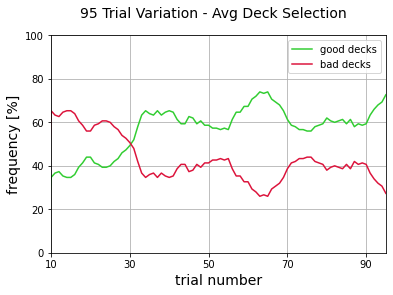

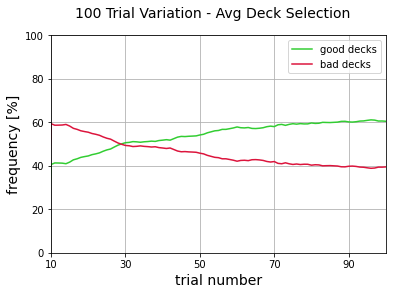

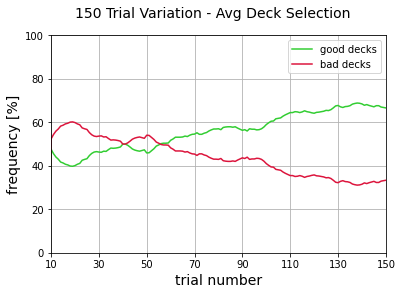

In [116]:
grouped_keys = list(grouped_choices.keys())
for i in range(0,3):
    ind = i * 4
    df_range = list(range(1, grouped_choices[grouped_keys[ind]].shape[1] + 1))
    
    fig = plt.figure()
    ax = fig.gca()
    plt.plot(df_range,(grouped_choices[grouped_keys[ind + 2]].fillna(0).mean() + grouped_choices[grouped_keys[ind + 3]].fillna(0).mean()) / 10 * 100, color = 'limegreen', label = 'good decks')
    plt.plot(df_range,(grouped_choices[grouped_keys[ind]].fillna(0).mean() + grouped_choices[grouped_keys[ind + 1]].fillna(0).mean()) / 10 * 100, color = 'crimson', label = 'bad decks')
    plt.xlabel('trial number', fontsize = 14)
    plt.ylabel('frequency [%]', fontsize = 14)
    fig.suptitle(grouped_keys[ind][-3:].strip('_') + ' Trial Variation - Avg Deck Selection', fontsize = 14)
    plt.xlim(10, df_range[-1])
    plt.ylim(0, 100)
    plt.legend()
    ax.xaxis.set_ticks(np.arange(10, df_range[-1] + 1, 20))
    plt.grid()
    plt.show()

In the above graphs, the bad decks (deck A and B) are the most popular at the beginning. However, subjects appear to begin to recognize the bad decks (decks C and D) after approximately 13 trials, as the frequency of bad decks declines. For both, the 95 and 100 Trial Variations, the good decks overtake the bad decks after around 30 trials. On average, it appears to take the subjects of the 150 Trial Variation longer to recognize and tend towards the good decks, with the frequency of the good decks surpassing the bad deck after 57 trials. Interestingly, at the 90 trial mark, subjects in the 150 Trial Variation are selecting good decks with a similar or worse frequency to the subjects in the other 2 trial variations. Performance, for those in the 150 Trial Variation, continues to improve after 100 trials, with the gap between the green and red line increasing. This supports our earlier speculation of why a larger proportion of subjects made a profits in the 150 Trial Variation - they're more likely to identify the good and bad decks, as they do more repetitions of the task.

In [117]:
# pick out a good and bad player and show their individual graphs

In [ ]:
# maybe contrast payoff scheme 3 to the others -> if so add payoff scheme to study data frame

In [ ]:
# prepare the data for clustering